# Reddit Sentiment Analysis - Experiment 2: BoW vs TF-IDF Comparison

This notebook compares different vectorization techniques (Bag of Words vs TF-IDF)
with various n-gram configurations for sentiment analysis on Reddit comments.

## Table of Contents
1. Setup and Dependencies
2. Data Loading and Preparation
3. Experiment Design and Configuration
4. Vectorization Comparison Framework
5. Model Training and Evaluation
6. Results Analysis and Comparison
7. MLflow Experiment Tracking

## 1. Setup and Dependencies

In [ ]:
pip install mlflow

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from itertools import product
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_recall_fscore_support, f1_score, roc_auc_score)

# MLflow imports
import mlflow
import mlflow.sklearn
from mlflow.tracking import MlflowClient

In [ ]:
# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## 2. Utility Functions for Experiment Framework

In [ ]:
def setup_mlflow_local():
    """Setup MLflow for local tracking."""
    try:
        mlflow.set_tracking_uri("file:./mlruns")
        print("✓ MLflow tracking URI set to local directory: './mlruns'")

        # Test connection
        with mlflow.start_run():
            mlflow.log_param("test_param", "connection_test")
            mlflow.log_metric("test_metric", 1.0)
        print("✓ MLflow connection test successful")

        return True
    except Exception as e:
        print(f"MLflow setup failed: {e}")
        return False

def create_vectorizer(vectorizer_type, ngram_range, max_features, min_df=2, max_df=0.8):
    """Create vectorizer based on type and parameters."""
    if vectorizer_type.lower() == "bow":
        return CountVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english'
        )
    elif vectorizer_type.lower() == "tfidf":
        return TfidfVectorizer(
            ngram_range=ngram_range,
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english'
        )
    else:
        raise ValueError("vectorizer_type must be 'bow' or 'tfidf'")

def evaluate_model_comprehensive(model, X_test, y_test, class_names):
    """Perform comprehensive model evaluation."""
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Basic metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_micro = f1_score(y_test, y_pred, average='micro')

    # Classification report
    class_report = classification_report(y_test, y_pred, output_dict=True)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'f1_micro': f1_micro,
        'classification_report': class_report,
        'confusion_matrix': conf_matrix,
        'predictions': y_pred,
        'prediction_probabilities': y_pred_proba
    }

def plot_confusion_matrix_enhanced(conf_matrix, class_names, title, figsize=(8, 6)):
    """Create enhanced confusion matrix plot."""
    plt.figure(figsize=figsize)

    # Calculate percentages
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

    # Create annotations with both count and percentage
    annotations = np.empty_like(conf_matrix).astype(str)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            annotations[i, j] = f'{conf_matrix[i, j]}\n({conf_matrix_norm[i, j]:.2%})'

    sns.heatmap(conf_matrix,
                annot=annotations,
                fmt='',
                cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()

    return plt

def plot_metrics_comparison(results_df, metric_name, title, figsize=(12, 8)):
    """Plot comparison of metrics across different configurations."""
    plt.figure(figsize=figsize)

    # Create pivot table for heatmap
    pivot_df = results_df.pivot_table(
        values=metric_name,
        index='vectorizer_type',
        columns='ngram_range_str',
        aggfunc='mean'
    )

    # Create heatmap
    sns.heatmap(pivot_df,
                annot=True,
                fmt='.4f',
                cmap='RdYlGn',
                center=pivot_df.mean().mean(),
                cbar_kws={'label': metric_name.replace('_', ' ').title()})

    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('N-gram Range', fontsize=12)
    plt.ylabel('Vectorizer Type', fontsize=12)
    plt.tight_layout()

    return plt

def plot_detailed_comparison(results_df, figsize=(15, 10)):
    """Create detailed comparison plots."""
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Vectorization Methods Comparison', fontsize=16, fontweight='bold')

    metrics = ['accuracy', 'f1_macro', 'f1_weighted', 'f1_micro']
    titles = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 'F1-Score (Micro)']

    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        row = idx // 2
        col = idx % 2

        # Create bar plot
        ax = axes[row, col]

        # Prepare data for plotting
        plot_data = results_df.copy()
        plot_data['config'] = plot_data['vectorizer_type'] + '_' + plot_data['ngram_range_str']

        sns.barplot(data=plot_data, x='config', y=metric, hue='vectorizer_type', ax=ax)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('Configuration', fontsize=10)
        ax.set_ylabel(title, fontsize=10)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title='Vectorizer')

        # Add value labels on bars
        for p in ax.patches:
            if not np.isnan(p.get_height()):
                ax.annotate(f'{p.get_height():.3f}',
                           (p.get_x() + p.get_width()/2., p.get_height()),
                           ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    return fig

def save_experiment_summary(results_df, filename="experiment_summary.csv"):
    """Save experiment results summary."""
    summary_stats = results_df.groupby(['vectorizer_type', 'ngram_range_str']).agg({
        'accuracy': ['mean', 'std'],
        'f1_macro': ['mean', 'std'],
        'f1_weighted': ['mean', 'std'],
        'f1_micro': ['mean', 'std']
    }).round(4)

    # Flatten column names
    summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
    summary_stats.reset_index(inplace=True)

    # Save to CSV
    summary_stats.to_csv(filename, index=False)
    print(f"✓ Experiment summary saved to {filename}")

    return summary_stats

## 3. Data Loading and Preparation

In [ ]:
reddit_df = pd.read_pickle("/content/reddit_processed.pkl")
reddit_df

,clean_comment,category,processed_comment
0,family mormon have never tried explain them t...,1,family mormon never tried explain still stare ...
1,buddhism has very much lot compatible with chr...,1,buddhism very much lot compatible christianity...
2,seriously don say thing first all they won get...,-1,seriously say thing first get complex explain ...
3,what you have learned yours and only yours wha...,0,learned want teach different focus goal not wr...
4,for your own benefit you may want read living ...,1,benefit may want read living buddha living chr...
...,...,...,...
37244,jesus,0,jesus
37245,kya bhai pure saal chutiya banaya modi aur jab...,1,kya bhai pure saal chutiya banaya modi aur jab...
37246,downvote karna tha par upvote hogaya,0,downvote karna tha par upvote hogaya
37247,haha nice,1,haha nice


In [ ]:
reddit_df['clean_comment'] = reddit_df['processed_comment']
reddit_df.drop(columns=['processed_comment'], inplace=True)
reddit_df.head()

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism very much lot compatible christianity...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1


In [ ]:
# missing values
reddit_df.isna().sum()

,0
clean_comment,0
category,0


In [ ]:
# empty comments
reddit_df[reddit_df['clean_comment'].str.strip() == '']

,clean_comment,category


In [ ]:
# Dataset overview
print(f"\nDataset Overview:")
print(f"Shape: {reddit_df.shape}")
print(f"Columns: {list(reddit_df.columns)}")


Dataset Overview:
Shape: (36662, 2)
Columns: ['clean_comment', 'category']


In [ ]:
reddit_df

,clean_comment,category
0,family mormon never tried explain still stare ...,1
1,buddhism very much lot compatible christianity...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal not wr...,0
4,benefit may want read living buddha living chr...,1
...,...,...
37244,jesus,0
37245,kya bhai pure saal chutiya banaya modi aur jab...,1
37246,downvote karna tha par upvote hogaya,0
37247,haha nice,1


In [ ]:
# Class distribution
class_distribution = reddit_df['category'].value_counts().sort_index()
class_labels = {-1: 'Negative', 0: 'Neutral', 1: 'Positive'}

print(f"\nClass Distribution:")
for category, count in class_distribution.items():
    label = class_labels[category]
    percentage = (count / len(reddit_df)) * 100
    print(f"  {label}: {count} ({percentage:.2f}%)")


Class Distribution:
  Negative: 8248 (22.50%)
  Neutral: 12644 (34.49%)
  Positive: 15770 (43.01%)


In [ ]:
reddit_df['category'] = reddit_df['category'].astype(float).astype(int)

## 4. Experiment Configuration

In [ ]:
print("\n" + "="*50)
print("EXPERIMENT CONFIGURATION")
print("="*50)

# Experiment parameters
experiment_config = {
    'vectorizer_types': ['bow', 'tfidf'],
    'ngram_ranges': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)],
    'max_features_options': [5000, 10000],
    'test_size': 0.2,
    'random_state': 42,
    'cv_folds': 5
}

# Model parameters
model_config = {
    'n_estimators': 200,
    'max_depth': 15,
    'random_state': 42,
    'n_jobs': -1
}

print(f"Experiment Configuration:")
print(f"  • Vectorizer Types: {experiment_config['vectorizer_types']}")
print(f"  • N-gram Ranges: {experiment_config['ngram_ranges']}")
print(f"  • Max Features: {experiment_config['max_features_options']}")
print(f"  • Test Size: {experiment_config['test_size']}")
print(f"  • Cross-validation Folds: {experiment_config['cv_folds']}")

print(f"\nModel Configuration:")
print(f"  • Algorithm: Random Forest")
print(f"  • N-estimators: {model_config['n_estimators']}")
print(f"  • Max Depth: {model_config['max_depth']}")

# Calculate total experiments
total_experiments = (len(experiment_config['vectorizer_types']) *
                    len(experiment_config['ngram_ranges']) *
                    len(experiment_config['max_features_options']))
print(f"\nTotal Experiments to Run: {total_experiments}")


EXPERIMENT CONFIGURATION
Experiment Configuration:
  • Vectorizer Types: ['bow', 'tfidf']
  • N-gram Ranges: [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3)]
  • Max Features: [5000, 10000]
  • Test Size: 0.2
  • Cross-validation Folds: 5

Model Configuration:
  • Algorithm: Random Forest
  • N-estimators: 200
  • Max Depth: 15

Total Experiments to Run: 20


## 5. Experiment Execution Framework

In [ ]:
def run_vectorization_experiment(vectorizer_type, ngram_range, max_features,
                                X_train, X_test, y_train, y_test, run_name):
    """Run a single vectorization experiment."""

    with mlflow.start_run() as run:
        # Set run metadata
        mlflow.set_tag("mlflow.runName", run_name)
        mlflow.set_tag("experiment_type", "vectorization_comparison")
        mlflow.set_tag("model_type", "RandomForestClassifier")
        mlflow.set_tag("vectorizer_type", vectorizer_type)
        mlflow.set_tag("description",
                      f"{vectorizer_type} vectorization with n-gram range {ngram_range} and {max_features} max features")

        # Create and fit vectorizer
        vectorizer = create_vectorizer(vectorizer_type, ngram_range, max_features)

        print(f"Fitting {vectorizer_type} vectorizer...")
        X_train_vectorized = vectorizer.fit_transform(X_train)
        X_test_vectorized = vectorizer.transform(X_test)

        print(f"    ✓ Feature matrix shape: {X_train_vectorized.shape}")
        print(f"    ✓ Feature density: {X_train_vectorized.nnz / (X_train_vectorized.shape[0] * X_train_vectorized.shape[1]):.4f}")

        # Log vectorizer parameters
        mlflow.log_param("vectorizer_type", vectorizer_type)
        mlflow.log_param("ngram_range", str(ngram_range))
        mlflow.log_param("max_features", max_features)
        mlflow.log_param("min_df", vectorizer.min_df)
        mlflow.log_param("max_df", vectorizer.max_df)
        mlflow.log_param("feature_matrix_shape", str(X_train_vectorized.shape))
        mlflow.log_param("feature_density", X_train_vectorized.nnz / (X_train_vectorized.shape[0] * X_train_vectorized.shape[1]))

        # Log model parameters
        mlflow.log_param("n_estimators", model_config['n_estimators'])
        mlflow.log_param("max_depth", model_config['max_depth'])
        mlflow.log_param("random_state", model_config['random_state'])

        # Train model
        print(f"Training Random Forest model...")
        model = RandomForestClassifier(**model_config)
        model.fit(X_train_vectorized, y_train)

        # Evaluate model
        print(f"Evaluating model performance...")
        evaluation_results = evaluate_model_comprehensive(
            model, X_test_vectorized, y_test, ['Negative', 'Neutral', 'Positive']
        )

        # Log metrics
        mlflow.log_metric("accuracy", evaluation_results['accuracy'])
        mlflow.log_metric("f1_macro", evaluation_results['f1_macro'])
        mlflow.log_metric("f1_weighted", evaluation_results['f1_weighted'])
        mlflow.log_metric("f1_micro", evaluation_results['f1_micro'])

        # Log per-class metrics
        class_report = evaluation_results['classification_report']
        for class_name, metrics in class_report.items():
            if isinstance(metrics, dict) and class_name not in ['accuracy', 'macro avg', 'weighted avg', 'micro avg']:
                class_label = class_labels.get(int(class_name), f'class_{class_name}')
                for metric_name, value in metrics.items():
                    mlflow.log_metric(f"{class_label}_{metric_name}", value)

        # Create and save confusion matrix
        conf_matrix_plot = plot_confusion_matrix_enhanced(
            evaluation_results['confusion_matrix'],
            ['Negative', 'Neutral', 'Positive'],
            f"Confusion Matrix: {vectorizer_type} {ngram_range}",
            figsize=(8, 6)
        )

        conf_matrix_filename = f"confusion_matrix_{vectorizer_type}_{ngram_range[0]}_{ngram_range[1]}_{max_features}.png"
        conf_matrix_plot.savefig(conf_matrix_filename, dpi=300, bbox_inches='tight')
        mlflow.log_artifact(conf_matrix_filename)
        conf_matrix_plot.close()

        # Save vectorizer and model
        vectorizer_filename = f"vectorizer_{vectorizer_type}_{ngram_range[0]}_{ngram_range[1]}_{max_features}.pkl"
        joblib.dump(vectorizer, vectorizer_filename)
        mlflow.log_artifact(vectorizer_filename)

        # Log model
        mlflow.sklearn.log_model(model, f"model_{vectorizer_type}_{ngram_range[0]}_{ngram_range[1]}_{max_features}")

        print(f"Experiment completed - Accuracy: {evaluation_results['accuracy']:.4f}")

        return {
            'run_id': run.info.run_id,
            'vectorizer_type': vectorizer_type,
            'ngram_range': ngram_range,
            'ngram_range_str': f"({ngram_range[0]}, {ngram_range[1]})",
            'max_features': max_features,
            'accuracy': evaluation_results['accuracy'],
            'f1_macro': evaluation_results['f1_macro'],
            'f1_weighted': evaluation_results['f1_weighted'],
            'f1_micro': evaluation_results['f1_micro'],
            'feature_matrix_shape': X_train_vectorized.shape,
            'feature_density': X_train_vectorized.nnz / (X_train_vectorized.shape[0] * X_train_vectorized.shape[1])
        }

## 6. MLflow Setup and Experiment Execution

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
mlflow.set_tracking_uri("file:///content/drive/MyDrive/mlflow_logs")

In [ ]:
print("\n" + "="*50)
print("MLFLOW SETUP AND EXPERIMENT EXECUTION")
print("="*50)

# Setup MLflow
print("\nSetting up MLflow...")
mlflow_setup_success = setup_mlflow_local()

if mlflow_setup_success:
    # Set experiment
    experiment_name = "BoW_vs_TfIdf_Comparison"
    mlflow.set_experiment(experiment_name)
    print(f"✓ MLflow experiment set: {experiment_name}")

# Prepare data split (single split for all experiments for fair comparison)
print(f"\nSplitting data for experiments...")
X_train, X_test, y_train, y_test = train_test_split(
    reddit_df['clean_comment'],
    reddit_df['category'],
    test_size=experiment_config['test_size'],
    random_state=experiment_config['random_state'],
    stratify=reddit_df['category']
)

print(f"✓ Data split completed:")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")

# Run all experiments
print(f"\nStarting {total_experiments} experiments...")
experiment_results = []

experiment_counter = 0
for vectorizer_type in experiment_config['vectorizer_types']:
    for ngram_range in experiment_config['ngram_ranges']:
        for max_features in experiment_config['max_features_options']:
            experiment_counter += 1

            print(f"\n{'='*60}")
            print(f"EXPERIMENT {experiment_counter}/{total_experiments}")
            print(f"{'='*60}")
            print(f"Vectorizer: {vectorizer_type}")
            print(f"N-gram Range: {ngram_range}")
            print(f"Max Features: {max_features}")

            run_name = f"{vectorizer_type}_{ngram_range[0]}_{ngram_range[1]}_maxfeat_{max_features}"

            try:
                result = run_vectorization_experiment(
                    vectorizer_type, ngram_range, max_features,
                    X_train, X_test, y_train, y_test, run_name
                )
                experiment_results.append(result)

            except Exception as e:
                print(f"Experiment failed: {e}")
                continue

print(f"\nAll experiments completed!")
print(f"Successfully completed: {len(experiment_results)}/{total_experiments} experiments")


MLFLOW SETUP AND EXPERIMENT EXECUTION

Setting up MLflow...
✓ MLflow tracking URI set to local directory: './mlruns'
MLflow setup failed: Could not find experiment with ID 147337520425050598

Splitting data for experiments...
✓ Data split completed:
  • Training samples: 29329
  • Test samples: 7333

Starting 20 experiments...

EXPERIMENT 1/20
Vectorizer: bow
N-gram Range: (1, 1)
Max Features: 5000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0024
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:45:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:45:50 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6352

EXPERIMENT 2/20
Vectorizer: bow
N-gram Range: (1, 1)
Max Features: 10000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0013
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:45:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:46:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6228

EXPERIMENT 3/20
Vectorizer: bow
N-gram Range: (1, 2)
Max Features: 5000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0025
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:46:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:46:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6289

EXPERIMENT 4/20
Vectorizer: bow
N-gram Range: (1, 2)
Max Features: 10000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0014
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:46:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:46:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6270

EXPERIMENT 5/20
Vectorizer: bow
N-gram Range: (1, 3)
Max Features: 5000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0025
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:46:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:46:48 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6296

EXPERIMENT 6/20
Vectorizer: bow
N-gram Range: (1, 3)
Max Features: 10000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0014
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:47:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:47:05 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6263

EXPERIMENT 7/20
Vectorizer: bow
N-gram Range: (2, 2)
Max Features: 5000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0004
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:47:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:47:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4301

EXPERIMENT 8/20
Vectorizer: bow
N-gram Range: (2, 2)
Max Features: 10000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0002
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:47:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:47:31 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4301

EXPERIMENT 9/20
Vectorizer: bow
N-gram Range: (2, 3)
Max Features: 5000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0004
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:47:43 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:47:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4305

EXPERIMENT 10/20
Vectorizer: bow
N-gram Range: (2, 3)
Max Features: 10000
Fitting bow vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0003
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:47:58 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:48:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4302

EXPERIMENT 11/20
Vectorizer: tfidf
N-gram Range: (1, 1)
Max Features: 5000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0024
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:48:11 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:48:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6334

EXPERIMENT 12/20
Vectorizer: tfidf
N-gram Range: (1, 1)
Max Features: 10000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0013
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:48:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:48:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6238

EXPERIMENT 13/20
Vectorizer: tfidf
N-gram Range: (1, 2)
Max Features: 5000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0025
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:48:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:48:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6314

EXPERIMENT 14/20
Vectorizer: tfidf
N-gram Range: (1, 2)
Max Features: 10000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0014
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:48:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:48:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6266

EXPERIMENT 15/20
Vectorizer: tfidf
N-gram Range: (1, 3)
Max Features: 5000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0025
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:49:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:49:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6322

EXPERIMENT 16/20
Vectorizer: tfidf
N-gram Range: (1, 3)
Max Features: 10000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0014
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:49:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:49:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.6197

EXPERIMENT 17/20
Vectorizer: tfidf
N-gram Range: (2, 2)
Max Features: 5000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0004
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:49:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:49:46 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4311

EXPERIMENT 18/20
Vectorizer: tfidf
N-gram Range: (2, 2)
Max Features: 10000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0002
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:49:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:49:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4316

EXPERIMENT 19/20
Vectorizer: tfidf
N-gram Range: (2, 3)
Max Features: 5000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 5000)
    ✓ Feature density: 0.0004
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:50:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:50:13 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4316

EXPERIMENT 20/20
Vectorizer: tfidf
N-gram Range: (2, 3)
Max Features: 10000
Fitting tfidf vectorizer...
    ✓ Feature matrix shape: (29329, 10000)
    ✓ Feature density: 0.0003
Training Random Forest model...
Evaluating model performance...


2025/07/31 03:50:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/31 03:50:28 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Experiment completed - Accuracy: 0.4312

All experiments completed!
Successfully completed: 20/20 experiments


## 7. Results Analysis and Visualization


RESULTS ANALYSIS AND VISUALIZATION

Experiment Results Summary:
                                   mean     std
vectorizer_type ngram_range_str                
bow             (1, 1)           0.6290  0.0088
                (1, 2)           0.6280  0.0013
                (1, 3)           0.6280  0.0023
                (2, 2)           0.4301  0.0000
                (2, 3)           0.4304  0.0002
tfidf           (1, 1)           0.6286  0.0068
                (1, 2)           0.6290  0.0034
                (1, 3)           0.6259  0.0089
                (2, 2)           0.4313  0.0004
                (2, 3)           0.4314  0.0003

Detailed results saved to: detailed_experiment_results.csv

Creating visualizations...


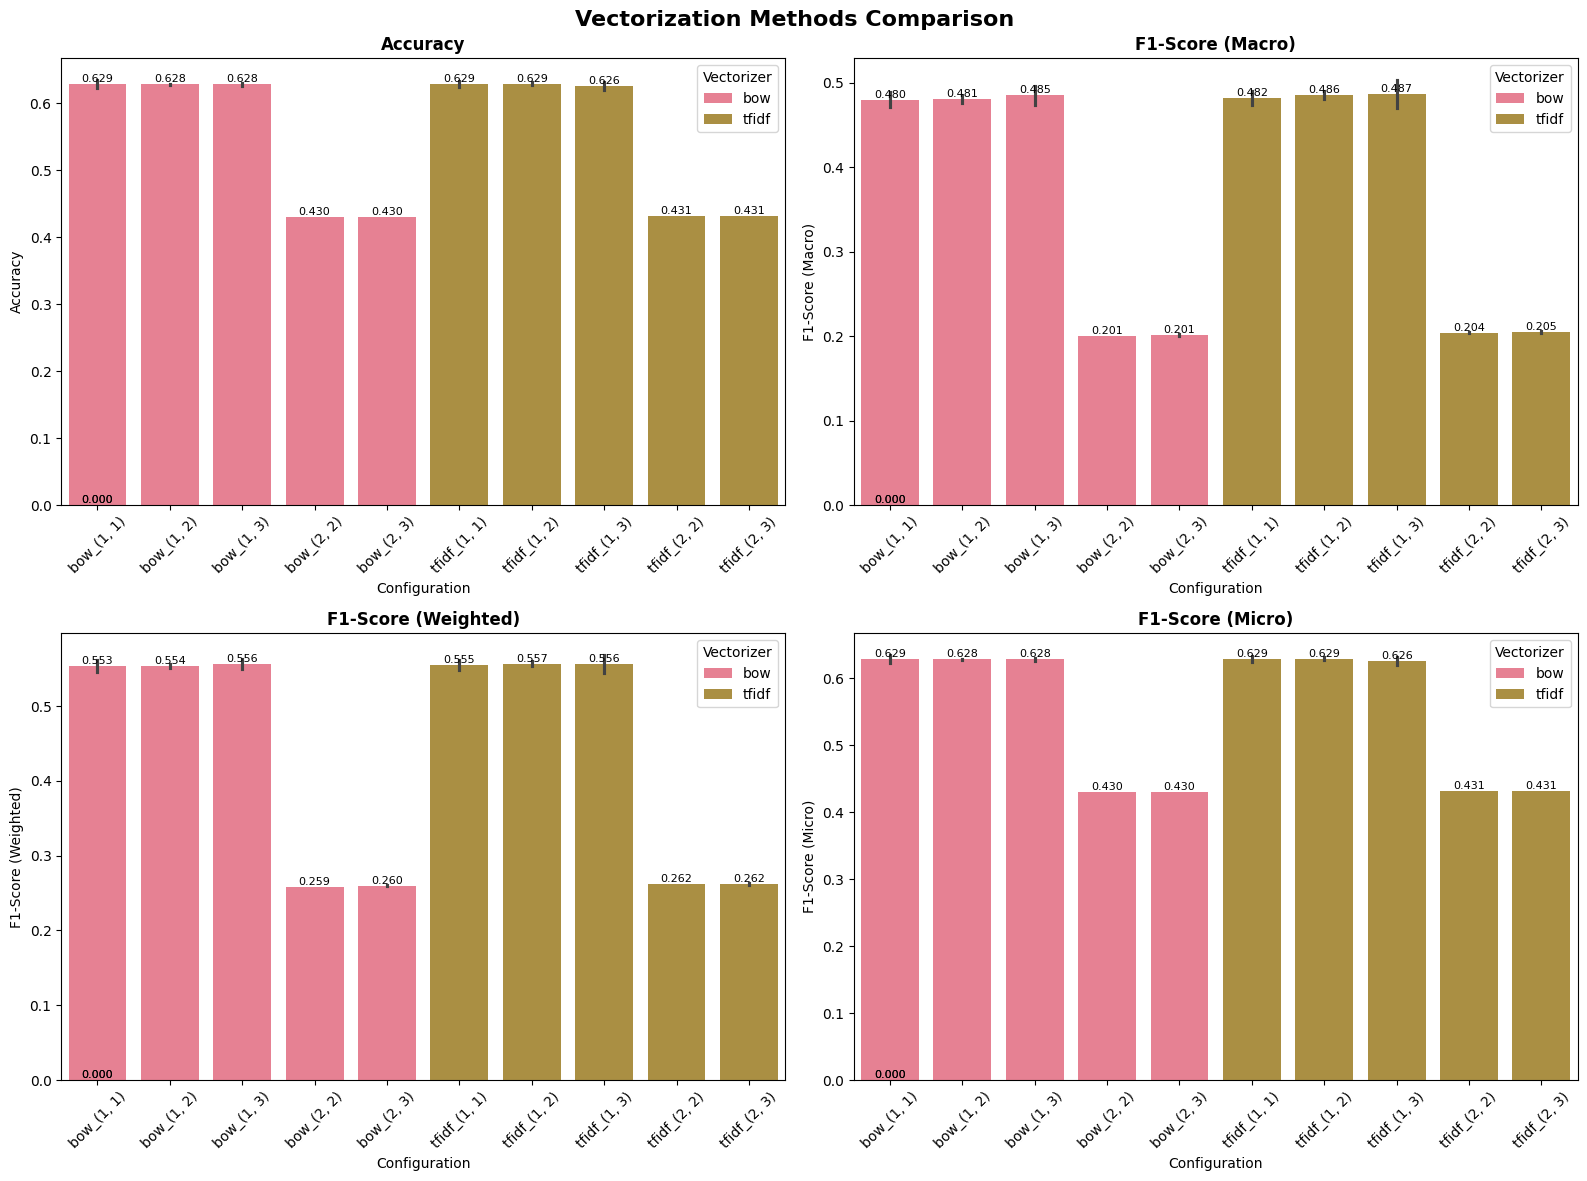

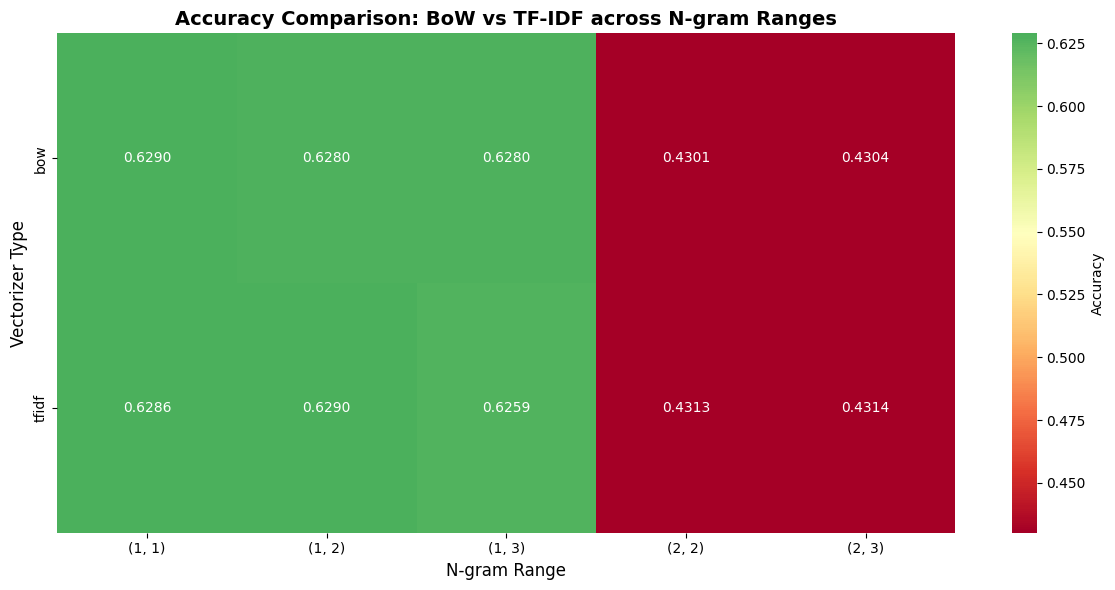

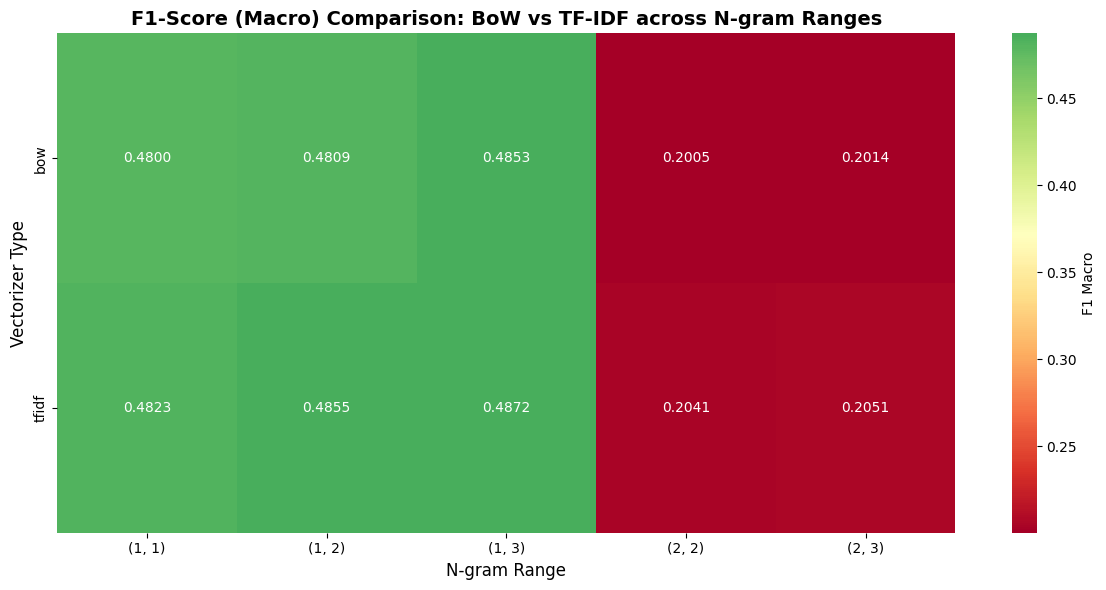

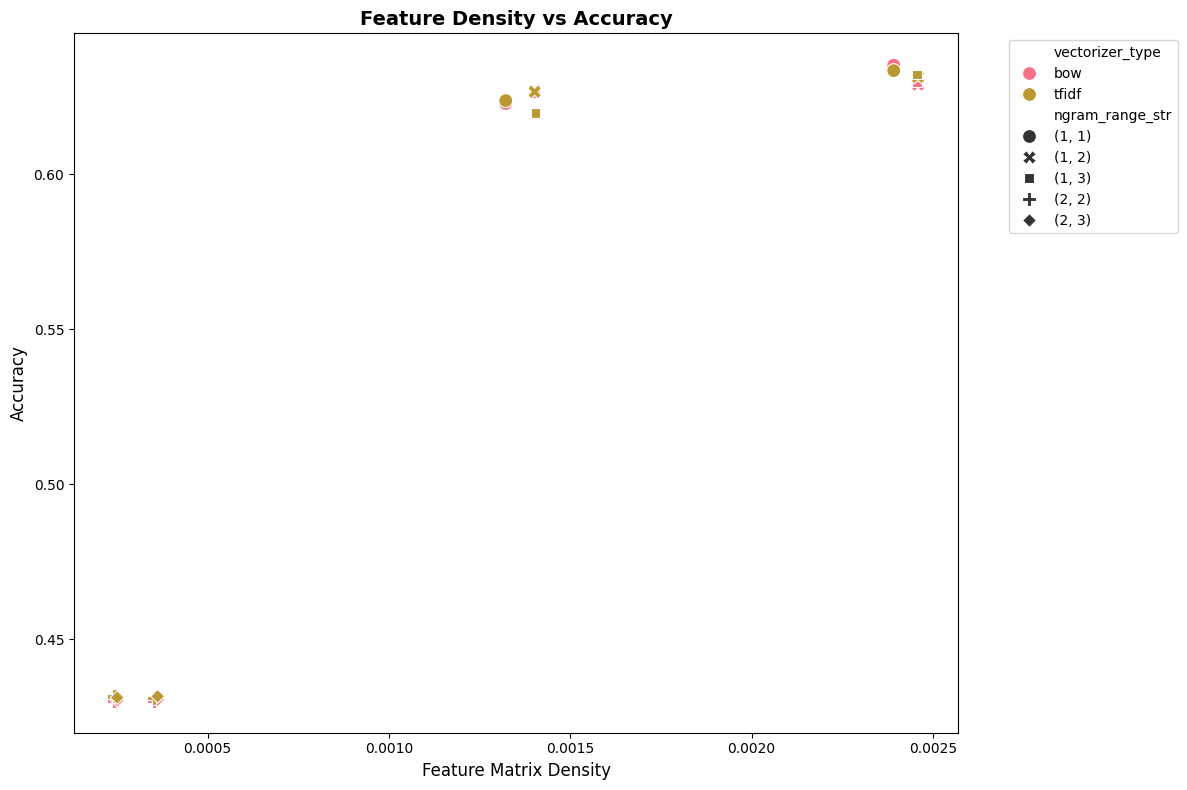

✓ Experiment summary saved to vectorization_experiment_summary.csv

Top 5 Configurations by Accuracy:
vectorizer_type ngram_range_str  max_features  accuracy  f1_macro
            bow          (1, 1)          5000  0.635211  0.488963
          tfidf          (1, 1)          5000  0.633438  0.490789
          tfidf          (1, 3)          5000  0.632211  0.503927
          tfidf          (1, 2)          5000  0.631392  0.490162
            bow          (1, 3)          5000  0.629620  0.496476

Best Overall Configuration:
  • Vectorizer: bow
  • N-gram Range: (1, 1)
  • Max Features: 5000
  • Accuracy: 0.6352
  • F1-Score (Macro): 0.4890
  • F1-Score (Weighted): 0.5612


In [ ]:
print("\n" + "="*50)
print("RESULTS ANALYSIS AND VISUALIZATION")
print("="*50)

# Convert results to DataFrame
results_df = pd.DataFrame(experiment_results)

if len(results_df) > 0:
    print(f"\nExperiment Results Summary:")
    print(results_df.groupby(['vectorizer_type', 'ngram_range_str'])['accuracy'].agg(['mean', 'std']).round(4))

    # Save detailed results
    results_df.to_csv("detailed_experiment_results.csv", index=False)
    print(f"\nDetailed results saved to: detailed_experiment_results.csv")

    # Create comprehensive visualizations
    print(f"\nCreating visualizations...")

    # 1. Detailed comparison plot
    comparison_fig = plot_detailed_comparison(results_df, figsize=(16, 12))
    comparison_fig.savefig("vectorization_comparison_detailed.png", dpi=300, bbox_inches='tight')

    if mlflow_setup_success:
        mlflow.log_artifact("vectorization_comparison_detailed.png")

    plt.show()

    # 2. Accuracy heatmap
    accuracy_heatmap = plot_metrics_comparison(
        results_df, 'accuracy',
        'Accuracy Comparison: BoW vs TF-IDF across N-gram Ranges',
        figsize=(12, 6)
    )
    accuracy_heatmap.savefig("accuracy_heatmap.png", dpi=300, bbox_inches='tight')

    if mlflow_setup_success:
        mlflow.log_artifact("accuracy_heatmap.png")

    plt.show()

    # 3. F1-Score comparison
    f1_heatmap = plot_metrics_comparison(
        results_df, 'f1_macro',
        'F1-Score (Macro) Comparison: BoW vs TF-IDF across N-gram Ranges',
        figsize=(12, 6)
    )
    f1_heatmap.savefig("f1_score_heatmap.png", dpi=300, bbox_inches='tight')

    if mlflow_setup_success:
        mlflow.log_artifact("f1_score_heatmap.png")

    plt.show()

    # 4. Feature density comparison
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=results_df, x='feature_density', y='accuracy',
                   hue='vectorizer_type', style='ngram_range_str', s=100)
    plt.title('Feature Density vs Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Feature Matrix Density', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("density_vs_accuracy.png", dpi=300, bbox_inches='tight')

    if mlflow_setup_success:
        mlflow.log_artifact("density_vs_accuracy.png")

    plt.show()

    # Save experiment summary
    summary_stats = save_experiment_summary(results_df, "vectorization_experiment_summary.csv")

    if mlflow_setup_success:
        mlflow.log_artifact("vectorization_experiment_summary.csv")
        mlflow.log_artifact("detailed_experiment_results.csv")

    print(f"\nTop 5 Configurations by Accuracy:")
    top_configs = results_df.nlargest(5, 'accuracy')[['vectorizer_type', 'ngram_range_str', 'max_features', 'accuracy', 'f1_macro']]
    print(top_configs.to_string(index=False))

    print(f"\nBest Overall Configuration:")
    best_config = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"  • Vectorizer: {best_config['vectorizer_type']}")
    print(f"  • N-gram Range: {best_config['ngram_range_str']}")
    print(f"  • Max Features: {best_config['max_features']}")
    print(f"  • Accuracy: {best_config['accuracy']:.4f}")
    print(f"  • F1-Score (Macro): {best_config['f1_macro']:.4f}")
    print(f"  • F1-Score (Weighted): {best_config['f1_weighted']:.4f}")

else:
    print("No successful experiments to analyze.")

## Experiments

In [ ]:
!pip install pyngrok

In [ ]:
from mlflow.tracking import MlflowClient

client = MlflowClient(tracking_uri="file:///content/drive/MyDrive/mlflow_logs")
experiments = client.search_experiments()

for exp in experiments:
    print(f"Name: {exp.name} | ID: {exp.experiment_id} | Artifact Location: {exp.artifact_location}")

Name: Reddit_Sentiment_Baseline | ID: 300921718200322684 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/300921718200322684
Name: BoW_vs_TfIdf_Comparison | ID: 147337520425050598 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/147337520425050598
Name: Default | ID: 0 | Artifact Location: file:///content/drive/MyDrive/mlflow_logs/0


In [ ]:
from google.colab import userdata
NGROK_AUTHTOKEN = userdata.get('NGROK_AUTHTOKEN')

In [ ]:
!ngrok config add-authtoken NGROK_AUTHTOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!fuser -k 5000/tcp

In [ ]:
import subprocess
import threading
from pyngrok import ngrok

# Tracking URI
tracking_uri = "file:///content/drive/MyDrive/mlflow_logs"

def start_mlflow_ui():
    subprocess.run(["mlflow", "ui", "--backend-store-uri", tracking_uri, "--port", "5000"])

threading.Thread(target=start_mlflow_ui).start()

public_url = ngrok.connect(5000)
print(f"Open MLflow UI at: NgrokTunnel: {public_url}")

Open MLflow UI at: NgrokTunnel: NgrokTunnel: "https://8d30cb5ff966.ngrok-free.app" -> "http://localhost:5000"


## 8. Final Summary

In [ ]:
print("\n" + "="*60)
print("EXPERIMENT SUMMARY AND RECOMMENDATIONS")
print("="*60)

if len(results_df) > 0:
    # Statistical analysis
    bow_results = results_df[results_df['vectorizer_type'] == 'bow']
    tfidf_results = results_df[results_df['vectorizer_type'] == 'tfidf']

    print(f"\nStatistical Summary:")
    print(f"BoW Average Accuracy: {bow_results['accuracy'].mean():.4f} (±{bow_results['accuracy'].std():.4f})")
    print(f"TF-IDF Average Accuracy: {tfidf_results['accuracy'].mean():.4f} (±{tfidf_results['accuracy'].std():.4f})")

    # Best configurations
    best_bow = bow_results.loc[bow_results['accuracy'].idxmax()]
    best_tfidf = tfidf_results.loc[tfidf_results['accuracy'].idxmax()]

    print(f"\nBest Configurations:")
    print(f"Best BoW: {best_bow['ngram_range_str']}, {best_bow['max_features']} features → {best_bow['accuracy']:.4f}")
    print(f"Best TF-IDF: {best_tfidf['ngram_range_str']}, {best_tfidf['max_features']} features → {best_tfidf['accuracy']:.4f}")

    # Recommendations
    print(f"\nRecommendations:")
    if bow_results['accuracy'].mean() > tfidf_results['accuracy'].mean():
        print(f"  • BoW generally performs better for this dataset")
    else:
        print(f"  • TF-IDF generally performs better for this dataset")

    # N-gram analysis
    ngram_performance = results_df.groupby('ngram_range_str')['accuracy'].mean().sort_values(ascending=False)
    print(f"  • Best N-gram range: {ngram_performance.index[0]} (avg accuracy: {ngram_performance.iloc[0]:.4f})")

    # Feature count analysis
    feature_performance = results_df.groupby('max_features')['accuracy'].mean().sort_values(ascending=False)
    print(f"  • Optimal max features: {feature_performance.index[0]} (avg accuracy: {feature_performance.iloc[0]:.4f})")


EXPERIMENT SUMMARY AND RECOMMENDATIONS

Statistical Summary:
BoW Average Accuracy: 0.5491 (±0.1023)
TF-IDF Average Accuracy: 0.5493 (±0.1015)

Best Configurations:
Best BoW: (1, 1), 5000 features → 0.6352
Best TF-IDF: (1, 1), 5000 features → 0.6334

Recommendations:
  • TF-IDF generally performs better for this dataset
  • Best N-gram range: (1, 1) (avg accuracy: 0.6288)
  • Optimal max features: 5000 (avg accuracy: 0.5514)
